In [1]:
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import cv2

In [2]:
train_data = pd.read_csv('mnist_train.csv')
train_data

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59997,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# Create a temporary dataframe.
temp_df = train_data

# Get the number of missing data points per column.
missing_values_count = temp_df.isnull().sum()

# Look at the number of missing points.
missing_values_count[:]

label    0
1x1      0
1x2      0
1x3      0
1x4      0
        ..
28x24    0
28x25    0
28x26    0
28x27    0
28x28    0
Length: 785, dtype: int64

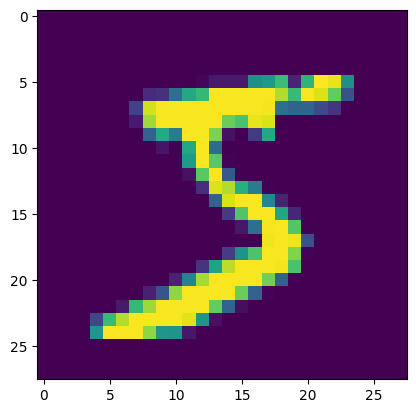

In [4]:
# Select relevant variables from the data.
X = train_data.iloc[:, 1:].values
y = train_data.iloc[:, 0].values

# Reshape X to have samples in the first dimension.
X_reshaped = X.reshape(X.shape[0], 28, 28)

plt.imshow(X_reshaped[0])

In [5]:
# Split the original dataset into training and test sets.
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.25, random_state=5)

# Split the training set further into training and development sets.
X_train, X_dev, y_train, y_dev = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=5)

Splitting the dataset into training and test sets is crucial because it allows the model to be trained using the training set. Subsequently, this training enables the model to make predictions on data from the test set.

In [6]:
X_train.shape

(33750, 784)

In [7]:
# Training a model without pruning.
unpruned = DecisionTreeClassifier(max_depth=None, random_state=5)
unpruned.fit(X_train, y_train)
print("Performance without pruning:", unpruned.score(X_test, y_test))
print("At depth:", unpruned.tree_.max_depth)

# Compute accuracy on development set.
accuracy_dev = unpruned.score(X_dev, y_dev)
print("Accuracy on Development Set:", accuracy_dev)

Performance without pruning: 0.8627333333333334
At depth: 43
Accuracy on Development Set: 0.8559111111111111


In [8]:
# Looking at effect of pruning.   
pruned_depths = range(1,unpruned.tree_.max_depth+1)

pruned_scores = [] 
for d in pruned_depths:
  clf = DecisionTreeClassifier(max_depth=d, random_state=5)
  clf.fit(X_train, y_train)
  score = clf.score(X_test, y_test)
  pruned_scores.append(score)

In [9]:
# Create Ensemble with Random Forest.
forest = RandomForestClassifier(max_depth=None, max_features='auto', max_leaf_nodes=None, 
                                n_estimators=100, random_state=5)
forest.fit(X_train, y_train)

/Users/micheleruggieri/Hyperiondev/.env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomForestClassifier(max_features='auto', random_state=5)

In [10]:
# Tune max_depth.
tuned_forest = RandomForestClassifier(max_depth=43, max_features='auto', max_leaf_nodes=None, 
                                      n_estimators=100, random_state=5)


The max_depth parameter in decision trees and random forests controls the maximum depth of each individual tree in the ensemble. A deeper tree can potentially capture more complex relationships in the data, but it also runs the risk of overfitting.

By setting max_depth to the maximum depth of the unpruned decision tree model (43), we're aiming to replicate the performance of the unpruned decision tree with our random forest. This could help us understand whether the random forest can achieve similar or better performance while reducing the risk of overfitting.

In [11]:
# Fit the model.
tuned_forest.fit(X_train, y_train)

# Evaluate Random Forest Performance.
tuned_accuracy = tuned_forest.score(X_test, y_test)
print("Tuned Random Forest Accuracy:", tuned_accuracy)


/Users/micheleruggieri/Hyperiondev/.env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Tuned Random Forest Accuracy: 0.9642666666666667


In [12]:
# Lists to store accuracies for training and development data.
train_accuracies = []
dev_accuracies = []

# Loop through different max_depth values.
for max_depth_value in range(1, 43):

    # Train a decision tree with the current max_depth.
    clf = DecisionTreeClassifier(max_depth=max_depth_value, random_state=5)
    clf.fit(X_train, y_train)
    
    # Calculate accuracy on training and development data.
    accuracy_train = clf.score(X_train, y_train)
    accuracy_dev = clf.score(X_dev, y_dev)
    
    # Append accuracies to lists.
    train_accuracies.append(accuracy_train)
    dev_accuracies.append(accuracy_dev)

In [13]:
# Train the final model.
final_model = DecisionTreeClassifier(max_depth=43, random_state=5)
final_model.fit(X_train, y_train)

# Evaluate the final model on the test data.
test_accuracy = final_model.score(X_test, y_test)

# Report the accuracy on the test data.
print("Accuracy on test data:", test_accuracy)


Accuracy on test data: 0.8627333333333334


The decision to train the final decision tree model with a max_depth of 43 and then evaluate it on the test data  aligns with the fact that we've been experimenting with different depths to understand how they affect model performance. By selecting a max_depth of 43, we're selecting a depth value that corresponds to the peak accuracy on your development data.

In [14]:
# Get predictions from the tuned random forest model on the test set.
predictions = tuned_forest.predict(X_test)

# Compute confusion matrix.
conf_matrix = confusion_matrix(y_test, predictions)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[1491    0    3    1    1    0    7    0   10    1]
 [   1 1620   12    6    2    0    5    5    5    0]
 [   5    1 1418   10    7    0    3    4   13    1]
 [   3    4   18 1471    0   18    3   20   18    7]
 [   3    1    2    1 1415    0    8    0    2   22]
 [   6    5    1   19    0 1229   17    0   10    5]
 [   6    0    1    0    3    7 1455    0    2    0]
 [   3   10   18    2    6    1    0 1568    3   17]
 [   5   10    9   13    8    8    7    3 1395   13]
 [   5    3    6   22   12    3    2   12   20 1402]]


Classes 2, 3, and 8 are among the ones where the model struggles more, as they have relatively high misclassification rates with multiple other classes.

### Calculate Accuracy
#### Accuracy=  Total Number of Predictions / Number of Correct Predictions
#### True Positives = 14664
#### Total Number of Predictions = 20000
#### Accuracy = 14664 / 20000 = 0.7332


### Calculate Precision
#### Precision= True Positives / (True Positives + False Positives)
#### Class 0 = 0.9847
#### Class 1 = 0.9810
#### Class 2 = 0.9707
#### Class 3 = 0.9679
#### Class 4 = 0.9730
#### Class 5 = 0.9643
#### Class 6 = 0.9871
#### Class 7 = 0.9641
#### Class 8 = 0.9655
#### Class 9 = 0.9586

### Calculate Recall
#### Recall= True Positives / (True Positives + False Negatives)
#### Class 0 = 0.984
#### Class 1 = 0.9812
#### Class 2 = 0.9700
#### Class 3 = 0.9409
#### Class 4 = 0.9711
#### Class 5 = 0.9432
#### Class 6 = 0.9871
#### Class 7 = 0.9620
#### Class 8 = 0.9469
#### Class 9 = 0.9449

### Calculate F1-score
#### F1-score = (2×Precision×Recall) / Precision+Recall
#### Class 0 = 0.9851
#### Class 1 = 0.9814
#### Class 2 = 0.9731
#### Class 3 = 0.9682
#### Class 4 = 0.9711
#### Class 5 = 0.9591
#### Class 6 = 0.9911
#### Class 7 = 0.9762
#### Class 8 = 0.9731
#### Class 9 = 0.9671


In [18]:
# Calculate precision, recall, and F1-score.
precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

Precision: 0.9641324172624943
Recall: 0.9640558016854698
F1-Score: 0.9640529851225971
